In [37]:
# !pip install -q accelerate -U
# !pip install -q bitsandbytes -U
# !pip install -q trl -U
# !pip install -q peft -U
# !pip install -q transformers -U
# !pip install -q datasets -U

## Data Preparation
Loading and preprocessing the medical dataset to ensure the data is clean and ready for training.

In [38]:
import pandas as pd
from datasets import load_dataset, Dataset, DatasetDict

df = pd.read_csv("hf://datasets/MattBastar/Medicine_Details/Medicine_Details.csv")
df = df.dropna()

In [39]:
df.head()

,Medicine Name,Composition,Uses,Side_effects,Image URL,Manufacturer,Excellent Review %,Average Review %,Poor Review %
0,Avastin 400mg Injection,Bevacizumab (400mg),Cancer of colon and rectum Non-small cell lun...,Rectal bleeding Taste change Headache Noseblee...,"https://onemg.gumlet.io/l_watermark_346,w_480,...",Roche Products India Pvt Ltd,22,56,22
1,Augmentin 625 Duo Tablet,Amoxycillin (500mg) + Clavulanic Acid (125mg),Treatment of Bacterial infections,Vomiting Nausea Diarrhea Mucocutaneous candidi...,"https://onemg.gumlet.io/l_watermark_346,w_480,...",Glaxo SmithKline Pharmaceuticals Ltd,47,35,18
2,Azithral 500 Tablet,Azithromycin (500mg),Treatment of Bacterial infections,Nausea Abdominal pain Diarrhea,"https://onemg.gumlet.io/l_watermark_346,w_480,...",Alembic Pharmaceuticals Ltd,39,40,21
3,Ascoril LS Syrup,Ambroxol (30mg/5ml) + Levosalbutamol (1mg/5ml)...,Treatment of Cough with mucus,Nausea Vomiting Diarrhea Upset stomach Stomach...,"https://onemg.gumlet.io/l_watermark_346,w_480,...",Glenmark Pharmaceuticals Ltd,24,41,35
4,Aciloc 150 Tablet,Ranitidine (150mg),Treatment of Gastroesophageal reflux disease (...,Headache Diarrhea Gastrointestinal disturbance,"https://onemg.gumlet.io/l_watermark_346,w_480,...",Cadila Pharmaceuticals Ltd,34,37,29


In [40]:
df["Uses"].value_counts()

Uses
Treatment of Type 2 diabetes mellitus                                                   907
Treatment of Bacterial infections                                                       439
 Hypertension (high blood pressure)                                                     405
 Pain relief                                                                            385
Treatment of Hypertension (high blood pressure)                                         279
                                                                                       ... 
Treatment of Hypertensive emergency                                                       1
 Eye infectionTreatment of Inflammatory conditionsTreatment of Autoimmune conditions      1
 Inflammation of gums Mouth ulcers Mouth infection                                        1
Treatment of Inflammation of gums Local anesthesia (Numb tissues in a specific area)      1
 Blood cancer (Acute lymphocytic leukemia)                                 

In [7]:
df['text'] = "\nMedicine Name: " + df["Medicine Name"] + "\nManufacturer: " + df["Manufacturer"] + "\nUses: " + df["Uses"] + "\nSide_effects: " + df["Side_effects"]

In [8]:
print(df['text'][0])


Medicine Name: Avastin 400mg Injection
Manufacturer: Roche Products India Pvt Ltd
Uses:  Cancer of colon and rectum Non-small cell lung cancer Kidney cancer Brain tumor Ovarian cancer Cervical cancer
Side_effects: Rectal bleeding Taste change Headache Nosebleeds Back pain Dry skin High blood pressure Protein in urine Inflammation of the nose


In [9]:
df = df[['Uses', 'text']]
df = df.rename(columns={'Uses': 'usecase'})

In [10]:
df.head()

,usecase,text
0,Cancer of colon and rectum Non-small cell lun...,\nMedicine Name: Avastin 400mg Injection\nManu...
1,Treatment of Bacterial infections,\nMedicine Name: Augmentin 625 Duo Tablet\nMan...
2,Treatment of Bacterial infections,\nMedicine Name: Azithral 500 Tablet\nManufact...
3,Treatment of Cough with mucus,\nMedicine Name: Ascoril LS Syrup\nManufacture...
4,Treatment of Gastroesophageal reflux disease (...,\nMedicine Name: Aciloc 150 Tablet\nManufactur...


In [11]:
dataset = Dataset.from_pandas(df)
dataset = dataset.shuffle(seed=0)
dataset = dataset.train_test_split(test_size=0.1)

In [12]:
dataset['test'][0]

{'usecase': 'Treatment of Type 2 diabetes mellitus',
 'text': '\nMedicine Name: Mopaday Forte Tablet ER\nManufacturer: Wockhardt Ltd\nUses: Treatment of Type 2 diabetes mellitus\nSide_effects: Headache Dizziness Hypoglycemia low blood glucose level Diarrhea Nausea Vomiting Flatulence Urinary tract infection Upper respiratory tract infection Edema swelling'}

## Hist Plot

In [65]:
dummy = df.copy()
dummy['usecase_tokens'] = dummy['usecase'].apply(lambda x: len(x.split())*1.5)
dummy['text_tokens'] = dummy['text'].apply(lambda x: len(x.split())*1.5)

<AxesSubplot:>

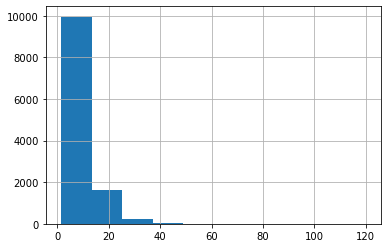

In [66]:
dummy['usecase_tokens'].hist()

<AxesSubplot:>

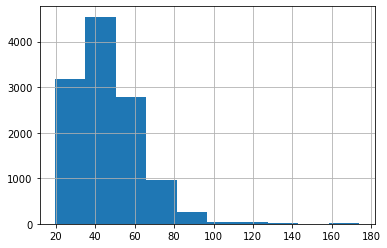

In [67]:
dummy['text_tokens'].hist()

Select 100 as the max_length of tokens

In [68]:
del dummy

## Prepare Formatting

In [3]:
def formatting_func(example):
    text = f"""
Given the usecase of medicines, you need to generate details of medicines.
### Usecase: {example['usecase']}
### Medicine Details: {example['text']}
"""
    return text

In [13]:
print(formatting_func(dataset['test'][0]))


Given the usecase of medicines, you need to generate details of medicines.
### Usecase: Treatment of Type 2 diabetes mellitus
### Medicine Details: 
Medicine Name: Mopaday Forte Tablet ER
Manufacturer: Wockhardt Ltd
Uses: Treatment of Type 2 diabetes mellitus
Side_effects: Headache Dizziness Hypoglycemia low blood glucose level Diarrhea Nausea Vomiting Flatulence Urinary tract infection Upper respiratory tract infection Edema swelling



## Load Base Model and Tokenize

In [14]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

base_model_id = "microsoft/phi-2"

model = AutoModelForCausalLM.from_pretrained(
    base_model_id, 
    trust_remote_code=True,
    torch_dtype=torch.float16, 
    load_in_8bit=True,
    device_map='auto',
)

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [75]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_size='left',
    add_eos_token=True,
    add_bos_token=True,
    use_fast=False
)

tokenizer.pad_token = tokenizer.eos_token

In [76]:
max_length = 100

def tokenize(prompt):
    result = tokenizer(
        formatting_func(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length"
    )

    result['labels'] = result['input_ids'].copy()

    return result

In [77]:
dataset = dataset.map(tokenize)

Map:   0%|          | 0/10642 [00:00<?, ? examples/s]

Map:   0%|          | 0/1183 [00:00<?, ? examples/s]

## LORA Config
Lets configure 8-bit QLORA Config

In [78]:
from peft import LoraConfig, get_peft_model

target_modules = ["Wqvk", "fc1", "fc2"]

config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=target_modules,
    bias = 'none',
    lora_dropout=0.05,
    task_type = 'CAUSAL_LM'
)

model = get_peft_model(model, config)

In [79]:
def print_trainable_parameters(model):
    trainable_params = 0
    all_params = 0
    for _, param in model.named_parameters():
        all_params += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f'trainable params: {trainable_params} || all params: {all_params} || trainable%: {100 * (trainable_params / all_params)}'
    )

print_trainable_parameters(model)

trainable params: 26214400 || all params: 2805898240 || trainable%: 0.9342605382581516


## Train the Model

In [83]:
from transformers import TrainingArguments, Trainer, DataCollatorForLanguageModeling
from datetime import datetime

# project = 'train_dir'
ckpt_steps = 75
run_name = 'phi-2_finetune_on_medicine_usecases'
output_dir = './' + run_name

args = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=2,
    gradient_accumulation_steps=1,
    max_steps=1500,
    learning_rate=2.5e-5, # Want a small lr for finetuning
    optim="paged_adamw_8bit",
    logging_steps=ckpt_steps,              # When to start reporting loss
    logging_dir="./logs",        # Directory for storing logs
    save_strategy="steps",       # Save the model checkpoint every logging step
    save_steps=ckpt_steps,                # Save checkpoints every 50 steps
    evaluation_strategy="steps", # Evaluate the model every logging step
    eval_steps=ckpt_steps,               # Evaluate and save checkpoints every 50 steps
    do_eval=True,                # Perform evaluation at the end of training
)

trainer = Trainer(
    model = model,
    args = args,
    train_dataset= dataset['train'],
    eval_dataset= dataset['test'],
    data_collator= DataCollatorForLanguageModeling(tokenizer, mlm=False)
)

model.config.use_cache = False

/home/mahfuj/.local/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
max_steps is given, it will override any value given in num_train_epochs


In [84]:
trainer.train()

Step,Training Loss,Validation Loss
75,1.924700,1.426007
150,1.277000,1.157454
225,1.130000,1.066771
300,1.104000,1.033498
375,1.027300,0.988244
450,1.002100,0.956067
525,0.932500,0.926753
600,0.933200,0.915259
675,0.966700,0.901136
750,0.946800,0.894401


TrainOutput(global_step=1500, training_loss=1.01043283589681, metrics={'train_runtime': 1441.7282, 'train_samples_per_second': 2.081, 'train_steps_per_second': 1.04, 'total_flos': 4814687232000000.0, 'train_loss': 1.01043283589681, 'epoch': 0.2819018981394475})

## Evaluation
### Generate Text with Tained Model | Load PEFT Model
Process-> Load base model,  then merge the PEFT Model

In [15]:
import torch
base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    trust_remote_code=True,
    load_in_8bit=True,
    torch_dtype=torch.float16
)

eval_tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=True,
    trust_remote_code=True,
    use_fast=False
)
eval_tokenizer.pad_token = eval_tokenizer.eos_token

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [16]:
from peft import PeftModel

ft_model = PeftModel.from_pretrained(base_model, './phi-2_finetune_on_medicine_usecases/checkpoint-1500/')

In [28]:
def generate(eval_prompt):
    model_input = eval_tokenizer(eval_prompt, return_tensors="pt")
    
    ft_model.eval()
    with torch.no_grad():
        output = ft_model.generate(**model_input, max_new_tokens=200, repetition_penalty=1.20)
        result = eval_tokenizer.decode(output[0], skip_special_tokens=True)
        
        return result

In [29]:
eval_prompt = """
Given the usecase of medicines, you need to generate details of medicines.
### Usecase: Treatment for Hypertension and Insomnia
### Medicine Details: 
"""

print(generate(eval_prompt))

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Given the usecase of medicines, you need to generate details of medicines.
### Usecase: Treatment for Hypertension and Insomnia
### Medicine Details: 
Medicine Name: Zydus-Prolo-SR Tablet SR
Manufacturer: Sun Pharmaceutical Industries Ltd
Uses:    Hypertension (high blood pressure)    Insomnia (inability to sleep)
Side_effects: Headache Dizziness Nausea Vomiting Diarrhea Flatulence Constipation Indigestion Abdominal pain Heartburn Nasopharyngitis Sinonasal congestion Cough Allergic reactions Rash Skin peeling Dry skin Itching Hair loss Increased liver enzymes in blood
Precautions: Do not take if you have low potassium level in blood Low sodium level in blood High cholesterol level in blood
Side effects: Headache Dizziness Nausea Vomiting Diarrhea Flatulence Constipation Indigestion Abdominal pain Heartburn Nasopharyngitis Sinonasal congestion Cough Allergic reactions Rash Skin peeling Dry skin Itching Hair loss Increased liver enzymes in blood
Precautions:


In [30]:
eval_prompt = """
Given the usecase of medicines, you need to generate details of medicines.
### Usecase: Treatment for Heart Attack and Heart Diseases
### Medicine Details: 
"""

print(generate(eval_prompt))

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Given the usecase of medicines, you need to generate details of medicines.
### Usecase: Treatment for Heart Attack and Heart Diseases
### Medicine Details: 
Medicine Name: Zydus Cadila Cardio-Plus Tablet SR
Manufacturer: Zydus Cadila Ltd
Uses:    Heart attack Prevention Heart failure Angina (heart pain)
Side_effects: Headache Nausea Vomiting Diarrhea Flatulence Abdominal discomfort Indigestion Dizziness Weakness Fatigue Palpitations Difficulty in sleeping Constipation Dry cough Blurred vision Increased liver enzymes Rash Itching Skin peeling Hair loss Decreased appetite Weight gain Flushing Sweating
Precautions: Do not take if you have any of the conditions stated below: Allergy to nitrates or nitrofurantoin Any condition of low blood pressure Low heart rate Kidney disease Liver disorder High cholesterol level
Dosage:    Oral tablet 50mg 100mg 200mg 300mg 400mg 500mg 600mg 800mg
Side_effects: Headache Nausea Vomiting Diarrhea Flatulence Abdominal discomfort


In [31]:
eval_prompt = """
Given the usecase of medicines, you need to generate details of medicines.
### Usecase: Treatment for Headaches and Migraines
### Medicine Details: 
"""

print(generate(eval_prompt))

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Given the usecase of medicines, you need to generate details of medicines.
### Usecase: Treatment for Headaches and Migraines
### Medicine Details: 
Medicine Name: Zomig CR Tablet SR
Manufacturer: Sun Pharmaceutical Industries Ltd
Uses:    Prevention and treatment of migraine headaches
Side_effects: Nausea Vomiting Dizziness Fatigue Weakness Tremors Insomnia Anxiety Depression Difficulty in sleeping Increased blood pressure Flushing Sweating Decreased appetite Constipation Diarrhea Flatulence Bloating Joint pain Muscle pain
### Usecase: Treatment of Neuropathic Pain
### Medicine Details: 
Medicine Name: Pregabalin Capsule ER
Manufacturer: Intas Pharmaceuticals Ltd
Uses:    Pain due to nerve damage
Side_effects: Sleepiness Tiredness Loss of coordination Confusion Impaired memory Uncoordinated body movements Drowsiness Dry mouth Weight gain Abnormal dreams Hallucinations Agitation Anxiety depression difficulty in sleep Increased sweating increased heart rate decreased blood pressure low

In [35]:
eval_prompt = """
Given the usecase of medicines, you need to generate details of medicines.
### Usecase: Treatment for Blood cancer
### Medicine Details: 
"""

print(generate(eval_prompt))

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Given the usecase of medicines, you need to generate details of medicines.
### Usecase: Treatment for Blood cancer
### Medicine Details: 
Medicine Name: Zydus Cadila Mabonit-M2 Tablet
Manufacturer: Zydus Cadila Ltd
Uses:    Treatment of Acute Myeloid Leukemia (AML) and Chronic myelomonocytic leukemia (CMML)
Side_effects: Nausea Vomiting Diarrhea Loss of appetite Headache Dizziness Fatigue Rash Skin redness Hair loss Joint pain Muscle weakness Abdominal pain Indigestion Constipation Increased liver enzymes Decreased white blood cell count Low platelet count low red blood cells low hemoglobin level low hematocrit level low lymphocyte count low neutrophil count low monocytes low bandemia low leukopenia low thrombocytopenia low reticulocyte count low bone marrow failure low white cell count low red blood cell count low hemoglobin level low hematocrit level low lymphocyte count low neutrophil count low monocytes low band


## Summary and Conclusion

### Summary
This notebook fine-tuned the **microsoft phi-2** model on a **medical dataset** to improve its accuracy and relevance in medical language generation. Key steps included:

1. **Data Preparation**: Preprocessed medical cases for effective training.
2. **Model Fine-Tuning**: Applied **LoRA** for parameter-efficient adaptation.
3. **Evaluation**: Measured accuracy, loss, and qualitative performance on test data.

### Conclusion
The fine-tuned model showed notable improvement in generating relevant medical responses. Future enhancements include:

- Expanding the **dataset** for broader medical coverage.
- Incorporating **feedback** from healthcare professionals for more nuanced model improvements.

> "Fine-tuning aimed to enhance model precision in medical contexts, improving its utility in healthcare applications."

**Thank you for exploring this notebook! Feel free to connect or provide feedback.** 😊